In [1]:
import numpy as np
from src.visualization.vis_utils import plot_point_cloud_3d, visualize_predictions
from src.cls.prediction import create_dataloader, predict_phases
import random
from hydra import compose, initialize
from omegaconf import DictConfig, OmegaConf
from warnings import filterwarnings
filterwarnings("ignore")
import torch

In [2]:
with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name="Al_classification.yaml")
print(OmegaConf.to_yaml(cfg))

training:
  learning_rate: 0.003
  batch_size: 2096
  epochs: 100
  decay_rate: 0.002
  gpu: true
  log_every_n_steps: 5
  num_workers: 4
data:
  cube_size: 8.0
  radius: 8.0
  sample_type: regular
  sample_shape: spheric
  n_samples: 800000
  num_points: 32
  overlap_fraction: 0.3
  data_path: datasets/Al/inherent_configurations_off
  liquid_files:
  - 166ps.off
  crystal_files:
  - 240ps.off
project_name: pointnet
experiment_name: 32_points_cls_defalut_loss
experiment_tags:
- cls



In [3]:
#change config if needed
# cfg.data.sample_shape = 'spheric'
cfg.data.num_points = 64
cfg.data.radius = 7.9
cfg.data.overlap_fraction = 0.5

file_path = 'datasets/Al/inherent_configurations_off/166ps.off'
liquid_dataloader = create_dataloader(cfg, file_path)
file_path = 'datasets/Al/inherent_configurations_off/240ps.off'
crystal_dataloader = create_dataloader(cfg, file_path)

Read 1048576 points
Size of space: [267.0368   267.035942 267.03684 ]
Min coords: [-8.0e-04  5.8e-05 -8.4e-04]
Max coords: [267.036 267.036 267.036]
Avg added 0.0 points, avg dropped 49.42 points
Number of samples in spheric dataset: 32768
Read 1048576 points
Size of space: [263.22167  263.219158 263.220081]
Min coords: [ 3.30e-04  8.42e-04 -8.10e-05]
Max coords: [263.222 263.22  263.22 ]
Avg added 0.0 points, avg dropped 51.78 points
Number of samples in spheric dataset: 32768


In [5]:

points_batch_l1, coords_batch_l1 = random.choice(list(liquid_dataloader))
points_l1 = points_batch_l1[0].numpy()
coords_l1 = np.array(coords_batch_l1)[:, 0]
print(f"Points shape: {points_l1.shape}")
print(f"Center coodinates: {coords_l1}")

fig = plot_point_cloud_3d(points_l1, n_connections=4)
fig.show()

Points shape: (64, 3)
Center coodinates: [15.7992   15.800058 15.79916 ]


In [6]:
points_batch_c1, coords_batch_c1 = random.choice(list(crystal_dataloader))
points_c1 = points_batch_c1[0].numpy()
coords_c1 = np.array(coords_batch_c1)[:, 0]
print(f"Points shape: {points_c1.shape}")
print(f"Center coodinates: {coords_c1}")

fig = plot_point_cloud_3d(points_c1, n_connections=4)
fig.show()

Points shape: (64, 3)
Center coodinates: [ 63.20033   47.400842 142.199919]


In [24]:
from src.loss.reconstruction_loss import calculate_rdf



r_max = 5
dr = 0.05
density = None
points_l1_tensor = torch.as_tensor(points_l1)
points_c1_tensor = torch.as_tensor(points_c1)
liquid_rdf = calculate_rdf(points_l1_tensor, sphere_radius=cfg.data.radius, dr=dr )[0][2:]
crystal_rdf = calculate_rdf(points_c1_tensor, sphere_radius=cfg.data.radius, dr=dr)[0][2:]



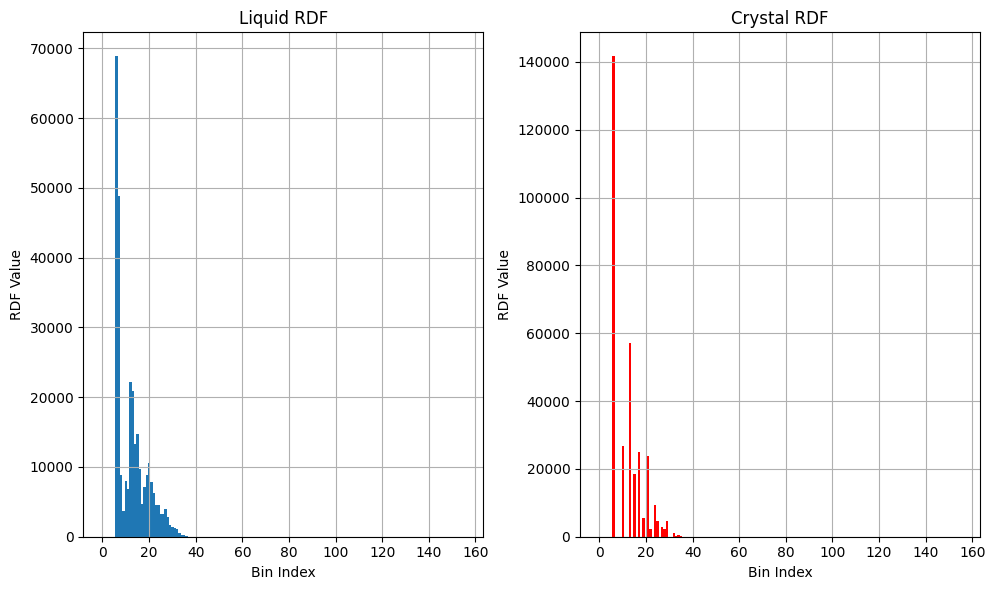

In [25]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.bar(range(len(liquid_rdf)), liquid_rdf.detach().numpy(), width=1.0)
ax1.set_xlabel('Bin Index')
ax1.set_ylabel('RDF Value') 
ax1.set_title('Liquid RDF')
ax1.grid(True)

ax2.bar(range(len(crystal_rdf)), crystal_rdf.detach().numpy(), width=1.0, color='red')
ax2.set_xlabel('Bin Index')
ax2.set_ylabel('RDF Value')
ax2.set_title('Crystal RDF') 
ax2.grid(True)

plt.tight_layout()
plt.show()



In [44]:
# from src.loss.reconstruction_loss import kl_divergence_loss, wasserstein_distance_loss   

def kl_divergence_loss(rdf1, rdf2):
    """
    Calculate symmetric KL divergence (Jensen-Shannon without 0.5 factor) between two RDFs
    
    Args:
        rdf1, rdf2: torch tensors of RDF values
    Returns:
        torch.Tensor: KL divergence loss
    """
    epsilon = 1e-10
    rdf1_norm = rdf1 / (torch.sum(rdf1) + epsilon)
    rdf2_norm = rdf2 / (torch.sum(rdf2) + epsilon)
    
    m = 0.5 * (rdf1_norm + rdf2_norm)
    loss = torch.sum(rdf1_norm * torch.log(rdf1_norm / (m + epsilon) + epsilon)) + \
           torch.sum(rdf2_norm * torch.log(rdf2_norm / (m + epsilon) + epsilon))
    return loss



def wasserstein_distance_loss(rdf1, rdf2):
    """
    Calculate approximate 1D Wasserstein distance between two RDFs using cumulative distributions
    
    Args:
        rdf1, rdf2: torch tensors of RDF values
    Returns:
        torch.Tensor: Wasserstein distance loss
    """
    epsilon = 1e-10
    rdf1_norm = rdf1 / (torch.sum(rdf1) + epsilon)
    rdf2_norm = rdf2 / (torch.sum(rdf2) + epsilon)
    
    cdf1 = torch.cumsum(rdf1_norm, dim=0)
    cdf2 = torch.cumsum(rdf2_norm, dim=0)
    loss = torch.sum(torch.abs(cdf1 - cdf2))
    return loss


def rdf_similarity_loss(rdf1, rdf2, method='kl'):

    if method == 'kl':
        return kl_divergence_loss(rdf1, rdf2)
    elif method == 'wasserstein':
        return wasserstein_distance_loss(rdf1, rdf2)


# kl_loss = nn.KLDivLoss(reduction="batchmean")

points_l2_tensor = liquid_dataloader.dataset[torch.randint(len(liquid_dataloader.dataset), (1,))][0]
points_c2_tensor = crystal_dataloader.dataset[torch.randint(len(crystal_dataloader.dataset), (1,))][0]


liquid_rdf2 = calculate_rdf(points_l2_tensor, sphere_radius=cfg.data.radius, dr=dr)[0][2:]
crystal_rdf2 = calculate_rdf(points_c2_tensor, sphere_radius=cfg.data.radius, dr=dr)[0][2:]


# Test all combinations
print("RDF Similarity Losses:")
print("\nKL divergence:")
print(f"Liquid-Crystal: {rdf_similarity_loss(liquid_rdf, crystal_rdf, method='kl').item():.4f}")
print(f"Liquid-Liquid: {rdf_similarity_loss(liquid_rdf, liquid_rdf2, method='kl').item():.4f}")
print(f"Crystal-Crystal: {rdf_similarity_loss(crystal_rdf, crystal_rdf2, method='kl').item():.4f}")

print("\nWasserstein distance:")
print(f"Liquid-Crystal: {rdf_similarity_loss(liquid_rdf, crystal_rdf, method='wasserstein').item():.4f}")
print(f"Liquid-Liquid: {rdf_similarity_loss(liquid_rdf, liquid_rdf2, method='wasserstein').item():.4f}") 
print(f"Crystal-Crystal: {rdf_similarity_loss(crystal_rdf, crystal_rdf2, method='wasserstein').item():.4f}")

RDF Similarity Losses:

KL divergence:
Liquid-Crystal: -76176448.0000
Liquid-Liquid: -60922376.0000
Crystal-Crystal: -6957678.0000

Wasserstein distance:
Liquid-Crystal: 0.7746
Liquid-Liquid: 0.1565
Crystal-Crystal: 1.2502


kl_loss time: 0.000414 seconds
kl_divergence_loss time: 0.000110 seconds

Results:
kl_loss: -76176448.0
kl_divergence_loss: 0.44131582975387573


tensor([-0.1076, -0.0454, -0.0785])

In [23]:
stophere

NameError: name 'stophere' is not defined

Mean Chamfer distances over 100 random pairs:
Crystal-Liquid: 0.0885 ± 0.0070
Liquid-Liquid: 0.0835 ± 0.0204
Crystal-Crystal: 0.0831 ± 0.0291

Mean Chamfer distances over 100 random pairs:
Crystal-Liquid: 0.0885 ± 0.0070
Liquid-Liquid: 0.0835 ± 0.0204
Crystal-Crystal: 0.0831 ± 0.0291